In [ ]:
# Only when using Google Colaboratory
!git clone https://github.com/namoshika/ssd_keras
%cd ssd_keras

In [ ]:
# Only when using Google Colaboratory
!pip install -U imgaug python_voc_parser tensorflow

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import bz2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pickle
import tensorflow as tf
import tensorflow.keras as keras
from pathlib import Path
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image

import src
import src.utils as utils

for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)


In [ ]:
# データセットをダウンロード
datset_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
datset_pth = keras.utils.get_file("VOCdevkit.tar", datset_url, extract=True)

file_pth = os.path.dirname(datset_pth)
dir_name = os.path.splitext(os.path.basename(datset_pth))[0]
dir_path = os.path.join(file_pth, dir_name)
dir_path = shutil.move(dir_path, "data/VOCdevkit/")

In [2]:
# 設定値
voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse','motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
num_classes=len(voc_classes)
img_size = (300, 300)


In [3]:
# モデル生成
model = src.core.SSD300(img_size, num_classes = num_classes)
model.build((None, *img_size, 3))
model.load_weights('data/weights_SSD300.hdf5', by_name=True)

optim = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=optim, loss=src.core.MultiboxLoss(num_classes, neg_pos_ratio=2.0).compute_loss)

checkpoint_path = './checkpoints/weights.{epoch:02d}-{val_loss:.2f}.ckpt'
callbks = [keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)]


In [4]:
# ETL生成
dat_dir = "data/VOCdevkit/VOC2007"
bbox_encoder = src.core.BoxEncoder(model.priorboxes, num_classes)
parser = src.data.PascalVocGenerator(dat_dir, 16, img_size, voc_classes, bbox_encoder)
utility = src.utils.Utility(bbox_encoder, voc_classes, parser.gt, parser.images_size)


In [ ]:
# ジェネレータ動作確認
ds = iter(parser.generate(True, augmentation_is_enable=False, preprocess_is_enabled=False))
ds_item = next(ds)

ds_im = ds_item[0].numpy()
ds_bx = ds_item[1].numpy()
ds_bx = bbox_encoder.decode(ds_bx)
for item_im, item_bx in zip(ds_im, ds_bx):
    plt.figure()
    item_bx = src.data.DetectResult.from_decoded_array(item_bx, voc_classes, item_im.shape)
    item_im = item_im.astype(np.uint8)
    utility.show_detection(item_bx, item_im)


In [ ]:
# チェックポイントの読込み
# latest_cp = tf.train.latest_checkpoint("./checkpoints")
# model.load_weights(latest_cp)


In [5]:
# ベース層の重み更新をロック
freeze = [
    'input_1',
    'conv1_1', 'conv1_2', 'pool1',
    'conv2_1', 'conv2_2', 'pool2',
    'conv3_1', 'conv3_2', 'conv3_3', 'pool3',
    # 'conv4_1', 'conv4_2', 'conv4_3', 'pool4',
]
for L in model.layers:
    L.trainable = not L.name in freeze


In [9]:
# モデルを訓練
res = model.fit(
    parser.generate(True),
    epochs=30, steps_per_epoch=parser.num_train_batches, callbacks=callbks,
    validation_data=parser.generate(False), validation_steps=parser.num_val_batches)


Train for 251 steps, validate for 63 steps
Epoch 1/30
250/251 [============================>.] - ETA: 0s - loss: 3.1146
Epoch 00001: saving model to ./checkpoints/weights.01-2.80.ckpt
251/251 [==============================] - 124s 493ms/step - loss: 3.1146 - val_loss: 2.8040
Epoch 2/30
250/251 [============================>.] - ETA: 0s - loss: 2.4736
Epoch 00002: saving model to ./checkpoints/weights.02-2.64.ckpt
251/251 [==============================] - 116s 460ms/step - loss: 2.4727 - val_loss: 2.6377
Epoch 3/30
250/251 [============================>.] - ETA: 0s - loss: 2.1927
Epoch 00003: saving model to ./checkpoints/weights.03-2.52.ckpt
251/251 [==============================] - 115s 459ms/step - loss: 2.1944 - val_loss: 2.5215
Epoch 4/30
250/251 [============================>.] - ETA: 0s - loss: 2.0348
Epoch 00004: saving model to ./checkpoints/weights.04-2.43.ckpt
251/251 [==============================] - 115s 458ms/step - loss: 2.0351 - val_loss: 2.4297
Epoch 5/30
250/251 [=

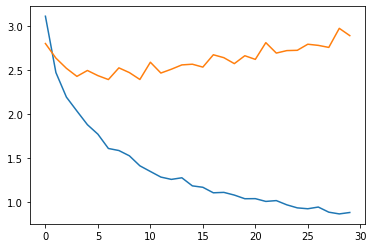

In [10]:
# 損失値の推移を表示
plt.plot(res.history["loss"])
plt.plot(res.history["val_loss"])


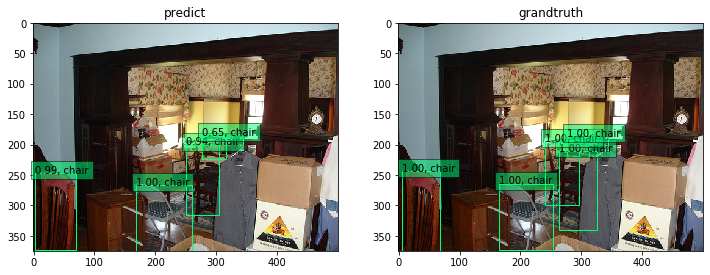

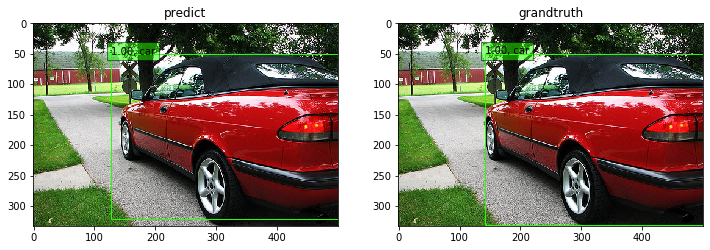

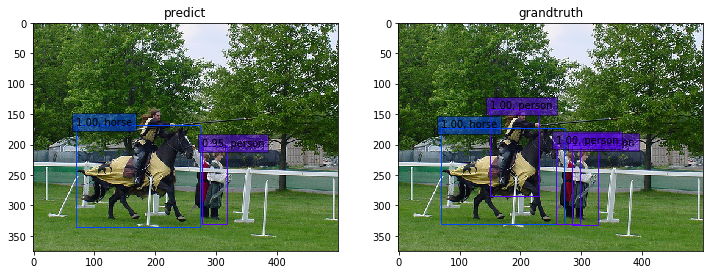

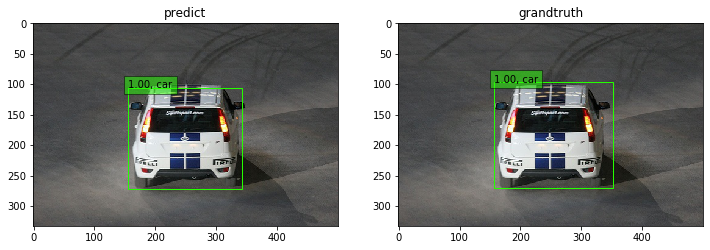

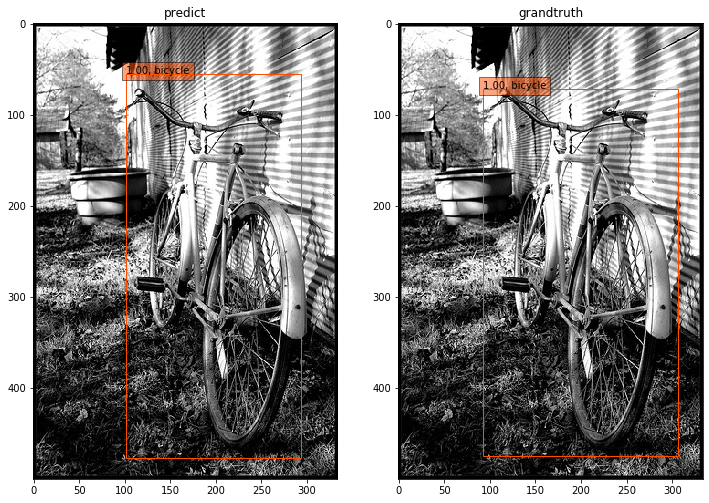

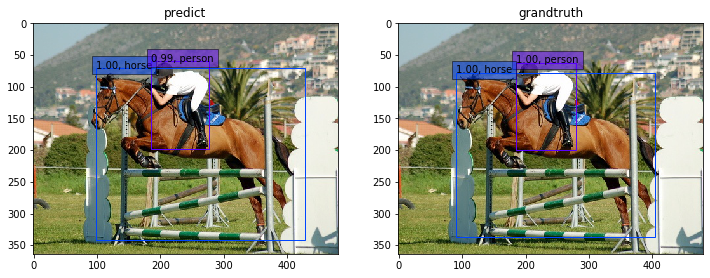

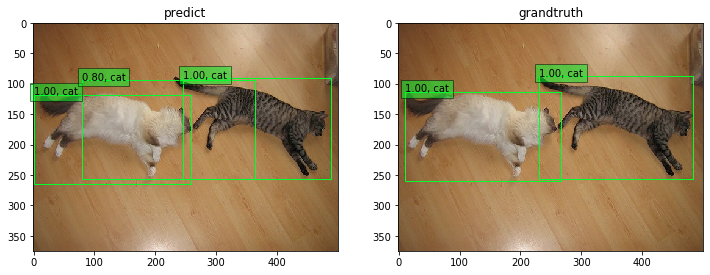

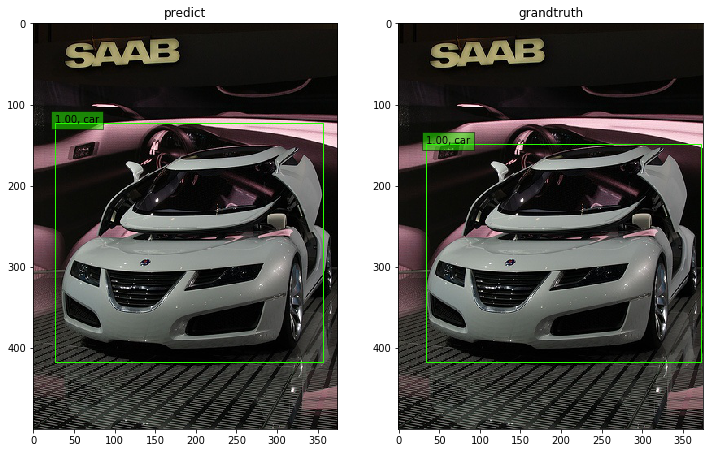

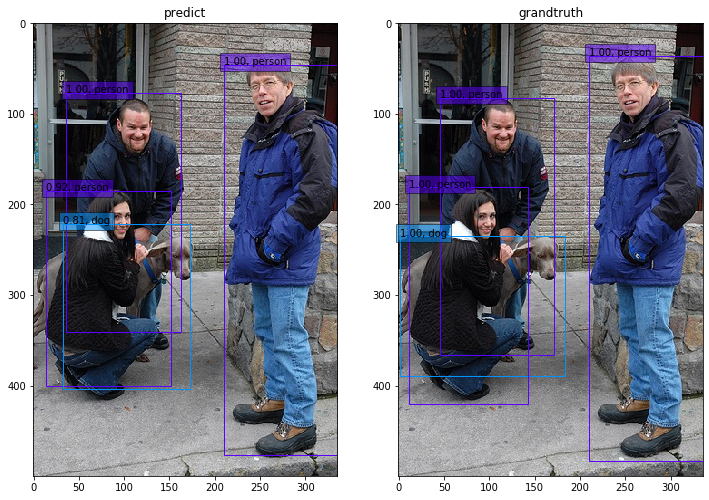

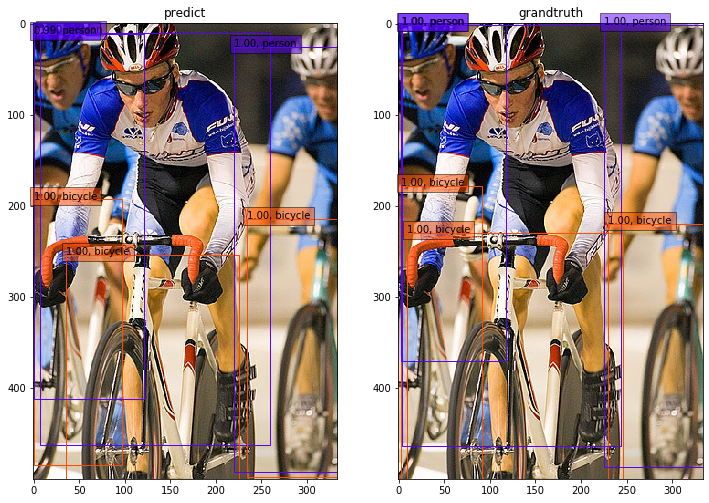

In [6]:
# VOC2007画像の推論結果表示
sample_dat = list(parser.gt.keys())[0:10]
utility.show_predict_with_gt(model, sample_dat, dat_dir)


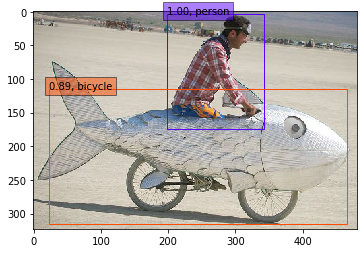

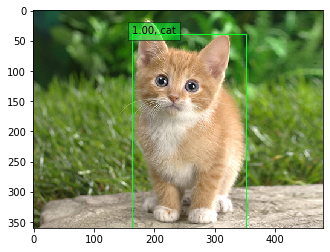

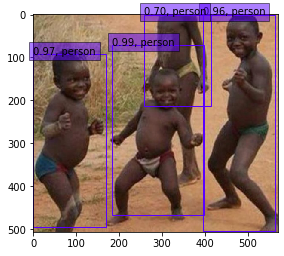

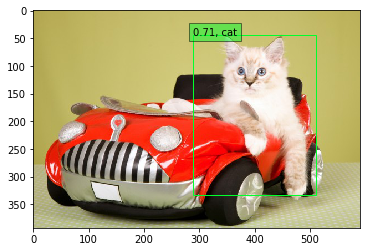

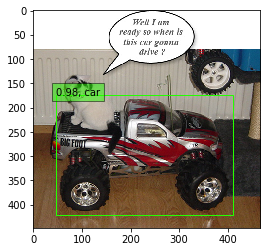

In [7]:
# サンプル画像の推論結果表示
utility.show_predict(model, [
    './data/fish-bike.jpg', './data/cat.jpg', './data/boys.jpg', 
    './data/car_cat.jpg', './data/car_cat2.jpg'
])


map:  0.7085651952060091


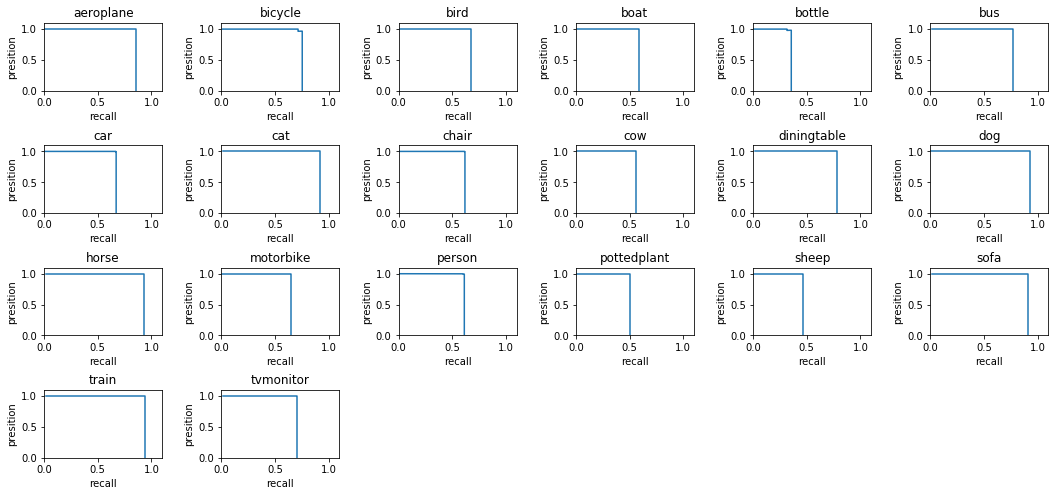

In [8]:
# 性能評価

# 推論値 & 正解値 のデータ生成
# keys = [key for key, gt in parser.keys_val]
# y_true = [src.data.DetectResult.from_decoded_array(parser.gt[key], voc_classes, parser.images_size[key]) for key in keys]
# y_pred = utility.get_predict(model, keys, dat_dir)
# with bz2.open("data/test_ytrue.pkl.bz2", "wb") as f:
#     dat_bytes = pickle.dumps(y_true)
#     f.write(dat_bytes)
# with bz2.open("data/test_ypred.pkl.bz2", "wb") as f:
#     dat_bytes = pickle.dumps(y_pred)
#     f.write(dat_bytes)

# 推論値 & 正解値 のデータ読込み
with bz2.open("data/test_ytrue.pkl.bz2", "rb") as f:
    y_true = dat_bytes = pickle.loads(f.read())
with bz2.open("data/test_ypred.pkl.bz2", "rb") as f:
    y_pred = dat_bytes = pickle.loads(f.read())

# ROCカーブ算出
utility.show_roccurve(y_pred, y_true)
# mAPスコア算出
meanap = utility.evaluate_meanap(y_pred, y_true)
print("map: ", meanap)
